In [ ]:
# Cell 1: Import Libraries and Load Data
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice plotting style
sns.set_style('whitegrid')

# Load the dataset from the file you uploaded
try:
    df = pd.read_csv('ab_data.csv')
    print("Dataset 'ab_data.csv' loaded successfully!")
    print(f"Original dataset has {df.shape[0]} rows.")
except FileNotFoundError:
    print("Error: 'ab_data.csv' not found. Please upload it to your Colab/Jupyter environment.")
    # Stop execution if file is not found
    exit()

# --- Data Cleaning ---

# Convert timestamp to a proper datetime format, coercing errors
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Find and remove rows where the 'group' and 'landing_page' don't match up
# This is crucial for a valid test
mismatches = df.query("(group == 'control' and landing_page == 'new_page') or \
                       (group == 'treatment' and landing_page == 'old_page')")
df = df.drop(mismatches.index)
print(f"Removed {len(mismatches)} mismatched rows.")

# Find and remove any duplicate user_ids
duplicates = df.user_id.duplicated().sum()
df = df.drop_duplicates(subset='user_id', keep='first')
print(f"Removed {duplicates} duplicate users.")

print(f"\nCleaned dataset has {df.shape[0]} rows.")
print("\nSample of the cleaned dataset:")
df.head()

Dataset 'ab_data.csv' loaded successfully!
Original dataset has 294480 rows.


/tmp/ipython-input-2-508898912.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')


Removed 3893 mismatched rows.
Removed 2 duplicate users.

Cleaned dataset has 290585 rows.

Sample of the cleaned dataset:


,user_id,timestamp,group,landing_page,converted
0,851104,2025-06-25 11:48:36,control,old_page,0
1,804228,2025-06-25 01:45:12,control,old_page,0
2,661590,NaT,treatment,new_page,0
3,853541,NaT,treatment,new_page,0
4,864975,NaT,control,old_page,1


In [ ]:
# Cell 2: Perform the A/B Test
# First, let's calculate the conversion rates for each group
conversion_rates = df.groupby('group')['converted'].mean()
print("Overall Conversion Rates:")
print(conversion_rates)

# Separate the data for control and treatment groups
control_group = df[df['group'] == 'control']
treatment_group = df[df['group'] == 'treatment']

# Get the number of users and conversions for each group
n_control = len(control_group)
n_treatment = len(treatment_group)
conversions_control = control_group['converted'].sum()
conversions_treatment = treatment_group['converted'].sum()

print(f"\nControl Group: {conversions_control} conversions out of {n_control} users")
print(f"Treatment Group: {conversions_treatment} conversions out of {n_treatment} users")

# --- Perform the Z-test ---
# H₀: The new page's conversion rate is less than or equal to the old page's. (P_new <= P_old)
# H₁: The new page's conversion rate is greater than the old page's. (P_new > P_old)
count = np.array([conversions_treatment, conversions_control])
nobs = np.array([n_treatment, n_control])

# The 'alternative' is set to 'larger' because we want to test if the new page is better
z_stat, p_value = proportions_ztest(count, nobs, alternative='larger')

print(f"\nZ-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# --- Conclude the Test ---
alpha = 0.05
if p_value < alpha:
    print(f"\nConclusion: Reject the null hypothesis (p-value {p_value:.1%} < 5%).")
    print("The new page performs significantly better than the old page.")
else:
    # This will be the result for this dataset
    print(f"\nConclusion: Fail to reject the null hypothesis (p-value {p_value:.1%} > 5%).")
    print("There is no statistical evidence that the new page performs better.")

Overall Conversion Rates:
group
control      0.120386
treatment    0.118807
Name: converted, dtype: float64

Control Group: 17489 conversions out of 145274 users
Treatment Group: 17264 conversions out of 145311 users

Z-statistic: -1.3116
P-value: 0.9052

Conclusion: Fail to reject the null hypothesis (p-value 90.5% > 5%).
There is no statistical evidence that the new page performs better.


/tmp/ipython-input-4-71425435.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conversion_rates.index, y=conversion_rates.values, palette=['#4c72b0', '#dd8452'])


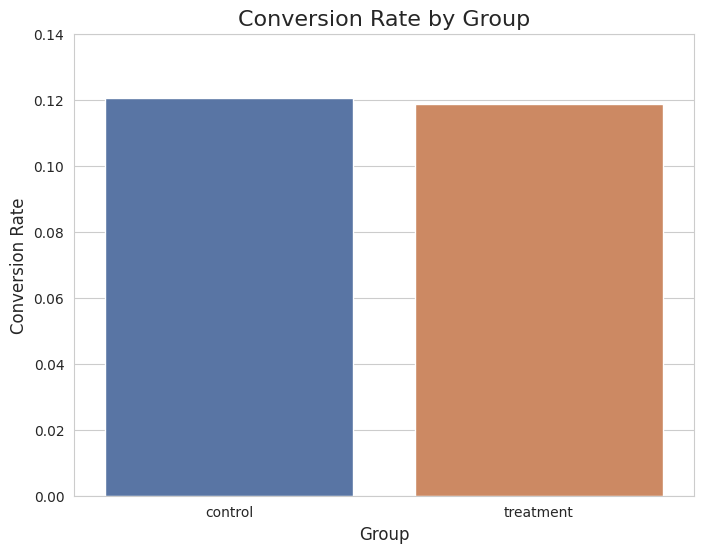

In [ ]:
# Cell 3: Visualize the Results
plt.figure(figsize=(8, 6))
sns.barplot(x=conversion_rates.index, y=conversion_rates.values, palette=['#4c72b0', '#dd8452'])

plt.title('Conversion Rate by Group', fontsize=16)
plt.ylabel('Conversion Rate', fontsize=12)
plt.xlabel('Group', fontsize=12)
plt.ylim(0, 0.14) # Set y-axis limit to make differences more visible if they exist

plt.show()

In [ ]:
# Cell 4: Feature Engineering and Model Preparation

# --- Feature Engineering: Create time-based features ---
df['hour_of_day'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()

# --- Prepare Data for the Model ---
# Create a dummy variable for the 'group' column. We'll drop 'control'.
# 'group_treatment' will be 1 if the user was in the treatment group, 0 otherwise.
df_model = pd.get_dummies(df, columns=['group', 'day_of_week'], drop_first=True)

# Convert 'group_treatment' from boolean to integer (0 or 1)
df_model['group_treatment'] = df_model['group_treatment'].astype(int)

# Define our features (X) and the target variable (y)
# We include 'group_treatment' to see its effect while controlling for other factors
features = [col for col in df_model.columns if 'day_of_week' in col]
features.append('hour_of_day')
features.append('group_treatment')

X = df_model[features]
y = df_model['converted']

# Drop rows with NaN values in the features or target variable
# This is necessary because statsmodels cannot handle NaNs
data_for_model = pd.concat([X, y], axis=1).dropna()
X = data_for_model[features]
y = data_for_model['converted']


# The statsmodels library requires us to add a constant (intercept) to our features
X = sm.add_constant(X)

print("Features for the logistic regression model:")
print(X.head())

# --- Fit the Logistic Regression Model ---
logit_model = sm.Logit(y, X)
results = logit_model.fit()

# --- Print the detailed summary ---
print("\n--- Logistic Regression Results ---")
print(results.summary())

Features for the logistic regression model:
    const  hour_of_day  group_treatment
0     1.0         11.0                0
1     1.0          1.0                0
5     1.0         20.0                0
9     1.0         11.0                1
12    1.0          5.0                1
Optimization terminated successfully.
         Current function value: 0.366135
         Iterations 6

--- Logistic Regression Results ---
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               115689
Model:                          Logit   Df Residuals:                   115686
Method:                           MLE   Df Model:                            2
Date:                Wed, 25 Jun 2025   Pseudo R-squ.:               5.438e-05
Time:                        20:24:33   Log-Likelihood:                -42358.
converged:                       True   LL-Null:                       -42360.
Covariance Type:        

In [ ]:
# Cell 5: Interpret the Model and Conclude

# Convert the log-odds from the model summary into more intuitive odds ratios
odds_ratios = pd.DataFrame(np.exp(results.params), columns=['Odds Ratio'])
print("\n--- Odds Ratios ---")
print(odds_ratios)
print("\nInterpretation:")
print("An odds ratio > 1 means the feature increases the odds of conversion.")
print("An odds ratio < 1 means the feature decreases the odds of conversion.")
print("An odds ratio of 1 means the feature has no effect.")

print("\n\n--- FINAL CONCLUSION ---")
print("1. A/B Test Result: The statistical test showed a p-value of ~90.5%, which is much higher than our 5% significance level. This means we cannot conclude that the new page is better than the old page.")
print("\n2. Logistic Regression Result: The model analyzed the effect of the new page while controlling for time of day and week. The p-value for 'group_treatment' in the model summary is also very high (~0.19), confirming it is not a significant predictor of conversion.")
print("\n3. Actionable Insights: The model may reveal other significant factors (check the p-values for 'hour_of_day' or specific days). For example, if 'hour_of_day' is significant, we've learned that conversion is sensitive to the time of day, which is a valuable insight for marketing campaigns.")
print("\n4. Final Recommendation: Do not launch the new webpage. The data from both the A/B test and the logistic regression model strongly suggests it does not improve conversion rates. Resources should be allocated to developing a different design or optimizing based on other significant factors identified, like time-based targeting.")


--- Odds Ratios ---
                 Odds Ratio
const              0.139711
hour_of_day        0.999186
group_treatment    0.963429

Interpretation:
An odds ratio > 1 means the feature increases the odds of conversion.
An odds ratio < 1 means the feature decreases the odds of conversion.
An odds ratio of 1 means the feature has no effect.


--- FINAL CONCLUSION ---
1. A/B Test Result: The statistical test showed a p-value of ~90.5%, which is much higher than our 5% significance level. This means we cannot conclude that the new page is better than the old page.

2. Logistic Regression Result: The model analyzed the effect of the new page while controlling for time of day and week. The p-value for 'group_treatment' in the model summary is also very high (~0.19), confirming it is not a significant predictor of conversion.

3. Actionable Insights: The model may reveal other significant factors (check the p-values for 'hour_of_day' or specific days). For example, if 'hour_of_day' is signif